## <center> **Livrable n°3 : Captioning d'image** </center>

‎ 

Réalisé par le **groupe n°2** :
- BERTHO Lucien
- BOSACKI Paul
- GAURE Warren
- GRENOUILLET Théo
- VALLEMONT Hugo


‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Démarche suivie](#demarche)
4. [Importation des bibliothèques](#import)
5. [Adaptation pour GPU](#gpu)
6. [Chargement et préparation des données](#chargement)
7. [Création du modèle de captioning](#model)
8. [Entraînement du modèle](#training)
9. [Évaluation du modèle](#evaluation)
10. [Métriques](#metrics)
11. [Conclusion](#conclusion)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

Pour cette troisième et dernière étape du workflow, il nous est demandé d'ajouter des légendes aux photos qui ont été traitées. Ce livrable propose une méthode de captioning basée sur les réseaux de neurones à convolution (CNN) ainsi que les récurrents (RNN) pour annoter les images fournies.

---

### 3. <a id='demarche'>Démarche suivie</a>

Pour ce livrable, nous avons fait le choix de représenter la démarche que nous avons décidé de suivre sous la forme d'un pipeline. Celui-ci représente les diverses grandes étapes que nous avons réalisé pour parvenir au but mentionné dans la partie précédente.

<center><img src="./results/pipeline_l3.png"></center>

---

### 4. <a id='import'>Importation des bibliothèques</a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import collections
import random
import re
import numpy as np
import os
import time
import json
import pickle

from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pathlib import Path
from glob import glob
from PIL import Image
from tqdm import tqdm

import evaluate as evaluate_metric
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

---

### 5. <a id='gpu'>Adaptation pour GPU</a>

Afin d'entraîner nos modèles sur le GPU de nos ordinateurs, une configuration est nécéssaire. Celle-ci va optimiser la demande de mémoire pour qu'elle soit allouée de manière croissante. Cela va permettre d'éviter d'allouer directement le maximum dès le début et éviter une surutilisation de celle-ci.

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(f"Nom du GPU détecté : {details.get('device_name', 'Nom inconnu')}")
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

---

### 6. <a id='chargement'>Chargement et préparation des données</a>

Une fois les bibliothèques importées et la configuration pour l'utilisation du GPU implémentée, nous pouvons commencer par charger les données.

#### 6.1. <a>Chargement des annotations</a>

Dans cette section, nous chargeons les textes associés avec les images du dataset COCO.

In [ ]:
ProjectPath = '/tf/'
#
## Chemin du fichier d'annotations
annotation_file = f"{ProjectPath}dataset_livrable_3/annotations/captions_train2014.json"
#
## Chemin du dossier contenant les images à annoter
PATH = f"{ProjectPath}dataset_livrable_3/train2014/train2014/"

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaq0+ ue annotation
    caption = '<start> ' + val['caption'] + ' <end>'
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:3000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))


On affiche les premières images du dataset ainsi que leurs annotations

In [ ]:
#Print the first 3 values of image_path_to_caption
for i, (key, value) in enumerate(image_path_to_caption.items()):
    if os.path.exists(key):
        if i == 3:
            break
        print(f"{key}: {value}")
        img = Image.open(key)
        plt.imshow(img)
        plt.axis("off")
        plt.show()

──────────────────────────────────────────────────

#### 6.2. <a>Chargement des images</a>

Ici, nous allons charger et prétraiter les images en créant un fichier contenant les features les plus importantes.

In [ ]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# Eécupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(inputs = new_input, outputs = hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

---

#### 6.3. <a>Création du tokenizer</a>

Nous allons ici créer un tokenizer. Il s'agit d'un outil qui convertit un texte brut en une séquence de unités de base appelées tokens (mots, sous-mots ou caractères), afin de rendre le texte exploitable par un modèle de machine learning.

In [ ]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)
    
# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

---

#### 6.4. <a>Création des jeux d'entraînement</a>

Nous crééons ici un dataset d'entraînement par le biais d'un fractionnement 80/20 de notre ensemble de données (80% pour l'entraînement et 20% our la validation).

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys = img_keys[:slice_index]
img_name_val_keys = img_keys[slice_index:]

"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

---

#### 6.5. <a>Chargement des photos prétraitées</a>

Enfin, nous allons charger les photos qui ont été traitées en amont, en veillant bien à les mélanger et les répartir dans des batchs.

In [ ]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

---

### 7. <a id='model'>Création du modèle de captioning</a>

Maintenant que les données ont été prétraitées et chargées correctement, nous pouvons procéder à la création du modèle qui va nous permettre d'automatiquement légender les photos issues des étapes précédentes du workflow.

#### 7.1. <a>Encodeur</a>

L’encodeur CNN est un module léger utilisé pour projeter les caractéristiques visuelles extraites d’une image (déjà pré-traitée par un réseau de type InceptionV3) dans un espace de plus petite dimension appelé espace d'embedding.  
 
Ce module contient une seule couche Dense composée de `embedding_dim` neurones, suivie d’une fonction d’activation ReLU.  
Son rôle est de réduire la dimension des descripteurs visuels (par ex. de `(64, 2048)` à `(64, 256)` si `embedding_dim = 256`), tout en conservant l'information nécessaire pour guider le décodeur dans la génération de la légende.

**Détails des couches utilisées :**

|     Couche     | Type  | Nombre de neurones |                                  Rôle                                        |
|----------------|-------|--------------------|------------------------------------------------------------------------------|
|      `fc`      | Dense |  `embedding_dim`   |               Réduction de dimensions des vecteurs d'image                   |
|  `activation`  | ReLu  |      `units`       | Introduit de la non-linéarité pour permettre un apprentissage plus expressif |

In [ ]:
@tf.keras.utils.register_keras_serializable('CNN_Encoder')
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim, **kwargs):
        super(CNN_Encoder, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    def get_config(self):
        config = super(CNN_Encoder, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
        })
        return config

──────────────────────────────────────────────────

#### 7.2. <a>Mécanisme de l'attention</a>

Le mécanisme d’attention de Bahdanau permet au décodeur de se concentrer dynamiquement sur les régions les plus pertinentes d’une image à chaque étape de génération de la légende.

Ce module calcule, pour chaque pas de temps, une pondération (poids d’attention) sur les vecteurs de caractéristiques extraits de l’image (par l’encodeur CNN), afin d’en dériver un vecteur de contexte. Ce vecteur est ensuite utilisé par le décodeur pour prédire le mot suivant de manière plus précise et contextualisée.

**Détails des couches utilisées :**

| Couche | Type  | Nombre de neurones |                               Rôle                                   |
|--------|-------|--------------------|----------------------------------------------------------------------|
|  `W1`  | Dense |      `units`       | Applique une projection linéaire aux features de l'image             |
|  `W2`  | Dense |      `units`       | Projette l'état caché du décodeur pour le combiner avec les features |
|  `V`   | Dense |         1          | Calcule un score d'attention pour chaque vecteur de feature          |

In [ ]:
@tf.keras.utils.register_keras_serializable('BahdanauAttention')
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(
                self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
    
    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            units: self.units,
        })
        return config

──────────────────────────────────────────────────

#### 7.3. <a>Décodeur</a>

Le décodeur RNN est un module séquentiel chargé de générer la légende de l’image mot par mot, en s’appuyant à chaque étape sur :

- le mot précédent généré (transformé en vecteur via un embedding)
- le vecteur de contexte issu du mécanisme d’attention
- l’état caché précédent

Ce décodeur existe sous deux variantes : une version basée sur un GRU (Gated Recurrent Unit), et une autre basée sur un LSTM (Long Short-Term Memory). Ces deux architectures permettent de modéliser des dépendances temporelles dans les séquences, tout en gérant l’oubli d’informations anciennes.

**Détails des couches utilisées :**

|    Couche     |       Type        |      Nombre de neurones       |                               Rôle                                   |
|---------------|-------------------|-------------------------------|----------------------------------------------------------------------|
|  `embedding`  |     Embedding     | `(vocab_size, embedding_dim)` | Convertit les mots (entiers) en vecteurs continus             |
|  `attention`  | BahdanauAttention |             `units`           | Calcule un vecteur de contexte pondéré à partir des features de l’image |
|    `fc1`      |       Dense       |             `units`           | (GRU uniquement) Réduit la concaténation `[contexte + embedding]` à une dimension compatible avec la GRU          |
|   `layer`     |    GRU ou LSTM    |             `units`           | Génère le nouvel état caché et une sortie intermédiaire          |
|    `fc2`      |       Dense       |           `vocab_size`        | Prédit le mot suivant en sortie (logits sur le vocabulaire)          |

In [ ]:
@tf.keras.utils.register_keras_serializable('RNN_Decoder')
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, use_lstm=False, **kwargs):
        super(RNN_Decoder, self).__init__(**kwargs)
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.use_lstm = use_lstm

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        if not use_lstm:
            self.layer = tf.keras.layers.GRU(
                self.units,
                return_sequences=True,
                return_state=True,
                activation='tanh',
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True,
            )
        else:
            self.layer = tf.keras.layers.LSTM(
                self.units,
                return_sequences=True,
                return_state=True,
                activation='tanh',
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True,
            )

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        context_vector = tf.expand_dims(context_vector, 1)
        
        x = tf.concat([context_vector, x], axis=-1)

        if not self.use_lstm:
            x = self.fc1(x)
            output, state = self.layer(x)
            y = tf.reshape(output, (-1, output.shape[2]))
        else:
            output, state, _ = self.layer(x)
            y = self.fc1(output)
            y = tf.reshape(y, (-1, y.shape[2]))

        y = self.fc2(y)

        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

    def get_config(self):
        config = super(RNN_Decoder, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
            'units': self.units,
            'vocab_size': self.vocab_size,
            'use_lstm': self.use_lstm
        })
        return config

In [ ]:
embedding_dim = 256
units = 512
vocab_size = top_k + 1

# Création de l'encodeur (CNN)
encoder = CNN_Encoder(embedding_dim)

# Création du décodeur (RNN avec attention)
decoderLSTM = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=True)
decoderGRU = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=False)

──────────────────────────────────────────────────

#### 7.4. <a>Optimizer</a>

L’optimiseur est l’algorithme chargé de mettre à jour les poids du modèle pendant l’apprentissage, en minimisant la fonction de perte.

In [ ]:
# Optimiseur ADAM
optimizer_LSTM = tf.keras.optimizers.Adam()
optimizer_GRU = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

---

### 8. <a id='training'>Entraînement du modèle</a>

#### 8.1. <a>Méthodes d'entraînement</a>

Le code ci-dessous est une étape de l'entrainement où nous initialisons l'entrée du décodeur et calculons la loss ainsi que le gradient pour mettre à jour les poids.

In [ ]:
def train_step(img_tensor, target, encoder, decoder, optimizer):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    # Enregistrement de la loss pour chaque batch
    return loss, total_loss

In [ ]:
def train_model(encoder, decoder, optimizer, dataset, epochs = 50, early_stopping = None):
    loss_plot = []
    strike = 0
    best_loss = float('inf')
    
    checkpoint_path = "./checkpoints/model"
    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

    # création des fichiers pour l'early stopping
    if early_stopping != None and not os.path.exists(f"{ProjectPath}/checkpoints/encoder.weights.h5"):
        Path(f'{ProjectPath}/checkpoints/encoder.weights.h5').touch()

    if early_stopping != None and not os.path.exists(f"{ProjectPath}/checkpoints/decoder.weights.h5"):
        Path(f'{ProjectPath}/checkpoints/decoder.weights.h5').touch()

    #if ckpt_manager.latest_checkpoint:
    #    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()

    for epoch in range(epochs):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target, encoder, decoder, optimizer)
            total_loss += t_loss

            #if batch % 50 == 0:
                #print('Epoch {}, Batch {}, Batch Loss {:.4f}, Time taken {:.2f} mins'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1]), (time.time() - start)/60))

        epoch_loss = total_loss / num_steps
        loss_plot.append(epoch_loss)

        # Sauvegarde du modèle uniquement si la perte est meilleure
        if float('%.2f' % (epoch_loss)) < best_loss: # Si vous trouver une meilleur façon pour arrondir le float, n'hésitez pas à le changer
            strike = 0
            best_loss = float('%.2f' % (epoch_loss))
            encoder.save_weights(f"{ProjectPath}/checkpoints/encoder.weights.h5")
            decoder.save_weights(f"{ProjectPath}/checkpoints/decoder.weights.h5")
            ckpt_save_path = ckpt_manager.save()
        else:
            strike += 1
            if early_stopping != None and strike >= early_stopping:
                encoder.load_weights(f"{ProjectPath}/checkpoints/encoder.weights.h5")
                decoder.load_weights(f"{ProjectPath}/checkpoints/decoder.weights.h5")
                print("Early stopping")
                break
        print('Result Epoch {}, Best Loss {}, Epoch Loss {}, Time taken {:.2f} mins, strike {}'.format(epoch + 1, best_loss, float('%.2f' % (epoch_loss)), (time.time() - start)/60, strike))
    
    return [loss_plot, best_loss, encoder, decoder, optimizer]

──────────────────────────────────────────────────

#### 8.2. <a>Entraînement</a>

In [ ]:
#results = train_model(encoder, decoderLSTM, optimizer_LSTM, dataset, epochs = 1, early_stopping = 10)
#
## Affichage de la courbe d'entrainement
#plt.plot(results[0])
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Loss Plot')
#plt.show()
#
##results[2].save('models/encoder_model.keras')  
##results[3].save('models/decoder_LSTM_model.keras')
#
#results[2].save_weights("models/encoder.weights.h5")
#results[3].save_weights("models/decoder_lstm.weights.h5")
#
#results = train_model(encoder, decoderGRU, optimizer_GRU, dataset, epochs = 1, early_stopping = 10)
#
### Affichage de la courbe d'entrainement
#plt.plot(results[0])
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Loss Plot')
#plt.show()
#
##results[3].save('models/decoder_GRU_model.keras')
#results[3].save_weights("models/decoder_gru.weights.h5")

<b style="color:yellow;">TODO</b>

Afficher le graphique et analyser les résultats.

──────────────────────────────────────────────────

#### 8.3. <a>Sauvegarde</a>

Le code suivant permet de sauvegarder les résultats obtenus sous la forme d'un fichier `.pickle`.

In [ ]:
#from pathlib import Path
#
## saving
#if not os.path.exists(f'{ProjectPath}/models/tokenizer.pickle'):
#    Path(f'{ProjectPath}/models/tokenizer.pickle').touch()
#with open(f'{ProjectPath}/models/tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

---

### 9. <a id="evaluation">Évaluation des modèles</a>

#### 9.1. <a>Chargement des poids</a>

In [ ]:
# loading
with open(f'{ProjectPath}/models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# Tu dois d'abord reconstruire les modèles (même structure qu'au training)
encoder_load = CNN_Encoder(embedding_dim)
decoder_load_lstm = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=True)
decoder_load_gru = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=False)


# Build the models by calling them with dummy data
dummy_image_features = tf.random.normal([1, attention_features_shape, features_shape])
dummy_caption_input = tf.random.uniform([1, 1], minval=0, maxval=vocab_size, dtype=tf.int32)
dummy_hidden_state = tf.zeros((1, units))

# Build the encoder by calling it with dummy data
_ = encoder_load(dummy_image_features)

# Build the decoder by calling it with dummy data
dummy_encoder_output = encoder_load(dummy_image_features)
_ = decoder_load_lstm(dummy_caption_input, dummy_encoder_output, dummy_hidden_state)
_ = decoder_load_gru(dummy_caption_input, dummy_encoder_output, dummy_hidden_state)


# Puis charger les poids
encoder_load.load_weights("models/encoder.weights.h5")
decoder_load_lstm.load_weights("models/decoder_lstm.weights.h5")
decoder_load_gru.load_weights("models/decoder_gru.weights.h5")

──────────────────────────────────────────────────

#### 9.2. <a>Méthode d'affichage de l'attention</a>

In [ ]:
# Function to display attention on the image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', 
        alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

──────────────────────────────────────────────────

#### 9.3. <a>Évaluation des deux versions</a>

Nous allons ici évaluer les performances de notre modèle de captioning en utilisant les deux décodeurs précédemment cités : GRU et LSTM.

##### 9.3.1. <a>Création des modèles et chargement des poids</a>

In [ ]:
def evaluate(image, decoder,encoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        temperature = 0.7  
        predictions = predictions / temperature
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        result.append(tokenizer.index_word[predicted_id])
    
        if tokenizer.index_word[predicted_id] == '<end>':
            break
        
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

────────────────────────────

##### 9.3.2. <a>Fonction de validation des annotations</a>

In [ ]:
# Fonction pour valider une légende
def is_valid_caption(caption):
    words = caption.split()

    # Critère 1 : au moins 5 mots
    if len(words) < 5:
        return False

    # Critère 2 : au moins 3 mots de au moins 5 lettres
    long_words = [w for w in words if len(w) >= 5]
    if len(long_words) < 3:
        return False

    # Critère 3 : pas plus de 2 occurrences du même mot
    lower_words = [w.lower() for w in words]
    word_counts = collections.Counter(lower_words)
    if any(count > 2 for count in word_counts.values()):
        return False

    return True

────────────────────────────

##### 9.3.3. <a>Création des captions</a>

In [ ]:
#import glob
#image_folder = "dataset_livrable_2/Results/denoised_photos/"
#image_files = glob.glob(f"{image_folder}/*.jpg")
#image = random.choice(image_files)
#index = None

#Choisir une image aléatoire
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
index = img_name_val.index(image)
real_caption = ' '.join([
    tokenizer.index_word[i]
    for i in cap_val[index]
    if i not in [0, tokenizer.word_index['<start>'], tokenizer.word_index['<end>']]
])

valid_captions_LSTM = []
valid_captions_GRU = []

# Boucle jusqu'à obtenir 5 captions valides par modèle
while len(valid_captions_LSTM) < 5 or len(valid_captions_GRU) < 5:
    result_LSTM, attention_plot_LSTM = evaluate(image, decoder_load_lstm,encoder_load)
    result_GRU, attention_plot_GRU = evaluate(image, decoder_load_gru,encoder_load)

    predicted_caption_LSTM = ' '.join([word for word in result_LSTM if word not in ['<start>', '<end>']])
    predicted_caption_GRU = ' '.join([word for word in result_GRU if word not in ['<start>', '<end>']])

    if len(valid_captions_LSTM) < 5 and is_valid_caption(predicted_caption_LSTM):
        valid_captions_LSTM.append((predicted_caption_LSTM, attention_plot_LSTM))

    if len(valid_captions_GRU) < 5 and is_valid_caption(predicted_caption_GRU):
        valid_captions_GRU.append((predicted_caption_GRU, attention_plot_GRU))

# Affichage final
print('Image Path:', image)
print('Real Caption:', real_caption)

# Affichage LSTM
print('LSTM Predictions:')
for i, (caption, attn) in enumerate(valid_captions_LSTM, 1):
    print(f'LSTM Prediction {i}:', caption)
    #plot_attention(image, caption.split(), attn)

# Affichage GRU
print('GRU Predictions:')
for i, (caption, attn) in enumerate(valid_captions_GRU, 1):
    print(f'GRU Prediction {i}:', caption)
    #plot_attention(image, caption.split(), attn)

# Afficher l'image originale
img = Image.open(image)
plt.imshow(img)
plt.axis("off")
plt.title("Image utilisée")
plt.show()

##### 9.3.4 <a>Exemple 1 :</a>

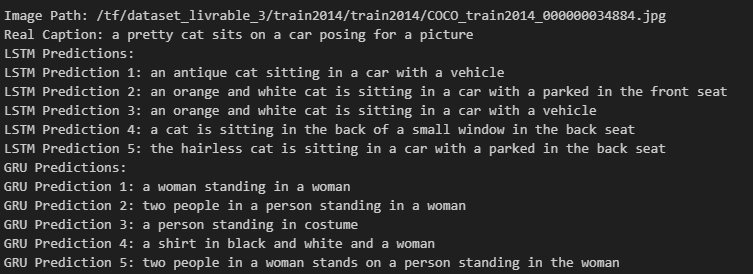

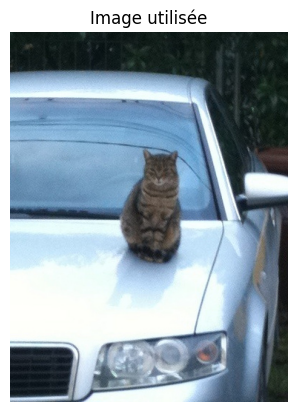

Sur cette image, nous pouvons observer que le modèle avec les prédictions **LSTM** possède de très **bons** résultats au point de détecter le chat, sa position ainsi que la voiture. De son côté, le modèle avec les prédictions **GRU** a des difficultés et n'arrive même pas à détecter des résultats cohérents sur l'image.

##### 9.3.5 <a>Exemple 2 :</a>

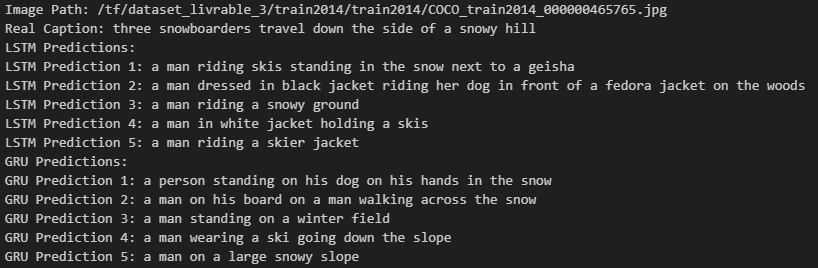

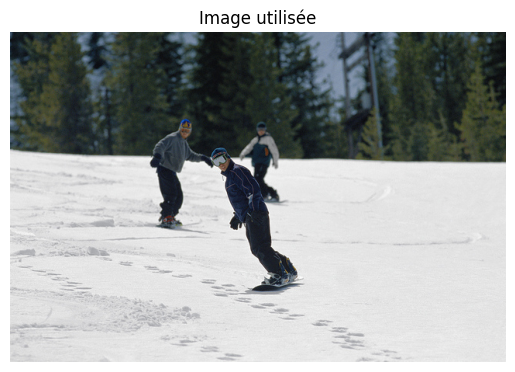

Sur cet exemple, nous pouvons observer que les deux modèles possèdent des résultats corrects. Ils observent tous les deux la présence d'une personne sur la neige. Cependant, la présence du snowboard n'a pas été détectée et est remplacée par du ski.  
Nous pouvons tout de même noter que le modèle avec les prédictions **LSTM** aborde un élément en plus que l'autre modèle : les vêtements de l'homme dans 2 prédictions (même si l'une des prédictions se trompe sur la couleur).

##### 9.3.6 <a>Exemple 3 :</a>

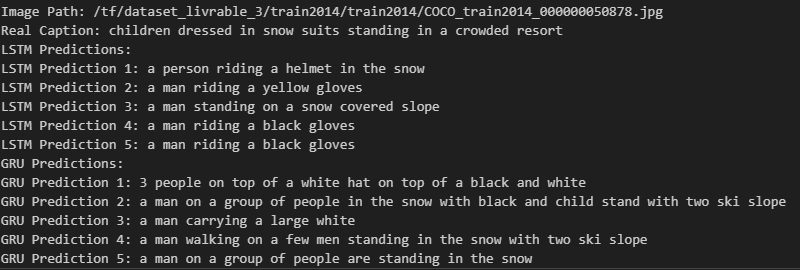

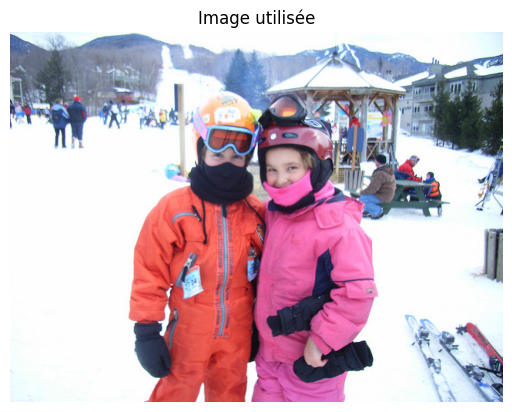

Dans ce cas, nous pouvons observer que nos prédictions ont encore des difficultés dans certains domaines. Ici, à l’exception de deux prédictions avec le modèle **GRU**, nous ne trouvons pas de notions de la présence de deux enfants sur l'image.  
Le modèle **LSTM** a même des difficultés avec la neige, en effet, celui-ci préfère insister sur la présence d'une personne et de la couleur de ses gants.  
Le modèle **GRU** possède des idées de bonnes réponses avec la présence de 3 personnes ou d'un groupe de personnes. Il aborde également le fait que les personnes sur l'image sont des enfants (même s'il n'en détecte qu'un), le tout en abordant souvent la présence de neige.

##### 9.3.7 <a>Calcul des métriques</a>

Pour évaluer la qualité des légendes générées par le modèle, plusieurs métriques de similarité de texte couramment utilisées en traitement automatique du langage naturel (TALN) ont été sélectionnées. Ces métriques permettent de quantifier la proximité linguistique et sémantique entre les légendes prédites et les légendes de référence associées aux images.

&nbsp;

**BLEU (Bilingual Evaluation Understudy)**
BLEU est une métrique fondée sur le taux de recouvrement de n-grammes entre la prédiction et les références. Elle est historiquement utilisée pour l’évaluation de la traduction automatique, mais s’applique également au captioning.  
Elle est adaptée pour mesurer la précision lexicale, mais tend à pénaliser les reformulations sémantiques correctes mais différentes des références.

&nbsp;

**METEOR (Metric for Evaluation of Translation with Explicit ORdering)**
METEOR complète les limites du BLEU en tenant compte de la racine des mots (stemming), des synonymes et de l’ordre des mots, ce qui la rend plus sensible à la variation sémantique.  
Elle est donc plus corrélée avec les jugements humains pour des phrases courtes et variées, comme celles produites en image captioning.

&nbsp;

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**
ROUGE, souvent utilisée en résumé automatique, mesure principalement le recouvrement de sous-séquences (n-grammes, longest common subsequence, etc.).  
Elle est utile pour évaluer la couverture du contenu informatif de la prédiction par rapport à la référence.

&nbsp;

**CIDEr (Consensus-based Image Description Evaluation)**
CIDEr est une métrique spécifiquement conçue pour l’évaluation de la génération de légendes d’images. Elle mesure la similarité entre les mots utilisés dans la légende générée et ceux des références, en tenant compte de la fréquence inverse des documents (TF-IDF).  
Elle privilégie donc les expressions rares et distinctives, souvent importantes pour capturer l’unicité d’une image. CIDEr est reconnu pour mieux refléter la qualité perçue par l’humain dans le cadre du captioning.

───────────────────

##### 9.3.7.1. **LSTM**

In [ ]:
# Metrics
bleus = []
rouges = []
meteors = []
CIDErs= []

#bleu = evaluate_metric.load("bleu", verbose=False)
meteor = evaluate_metric.load("meteor", verbose=False)
rouge = evaluate_metric.load("rouge", verbose=False)
#cider_scorer = Cider()
for i, (caption, attn) in enumerate(valid_captions_LSTM, 1):
    predictions = [caption]
    references = [[real_caption]]

    # BLEU
    smooth = SmoothingFunction().method4
    score = sentence_bleu(caption.split(), real_caption.split(), smoothing_function=smooth)
    bleus.append(score)

    # METEOR
    meteors.append(meteor.compute(predictions=predictions, references=references)["meteor"])

    # ROUGE
    rouges.append(rouge.compute(predictions=predictions, references=references)["rougeLsum"])

    gts = {
        "img1": [{"caption": real_caption}],
    }
    res = {
        "img1": [{"caption": caption[0]}],
    }

    # CIDEr & SPICE utilisent java et du coup peuvent faire des erreurs si pas installé ou pas la bonne version 

    # CIDEr
    # PTBtokenizer = PTBTokenizer()
    # gts = PTBtokenizer.tokenize(gts)
    # res = PTBtokenizer.tokenize(res)

    # score, scores = cider_scorer.compute_score(gts, res)
    # CIDErs.append(score)

    # SPICE
    # spice_scorer = Spice()
    # score, scores = spice_scorer.compute_score(gts, res)
    # print(f"SPICE: {score:.4f}")

In [ ]:
x = ["caption " + str(i) for i in range(len(bleus))]
metrics = [bleus, rouges, meteors] #, CIDErs]
labels = ['BLEU', 'ROUGE', 'METEOR'] #, 'CIDEr']
colors = ['blue', 'red', 'green'] #, 'orange']

plt.figure(figsize=(10, 6))
bottom = np.zeros(len(x))  # Hauteur de départ pour chaque segment

for i, (metric, name, color) in enumerate(zip(metrics, labels, colors)):
    bars = plt.bar(x, metric, bottom=bottom, label=name, color=color)

    # Annoter chaque segment
    for xi, yi, base in zip(x, metric, bottom):
        if yi > 0:
            plt.text(xi, base + yi / 2, f'{yi:.2f}', ha='center', va='center', fontsize=9, color='white')

    # Mise à jour de la hauteur de base
    bottom += metric

plt.ylabel('Score')
plt.title('Métrics empilés par caption')
plt.legend()
plt.tight_layout()
plt.show()

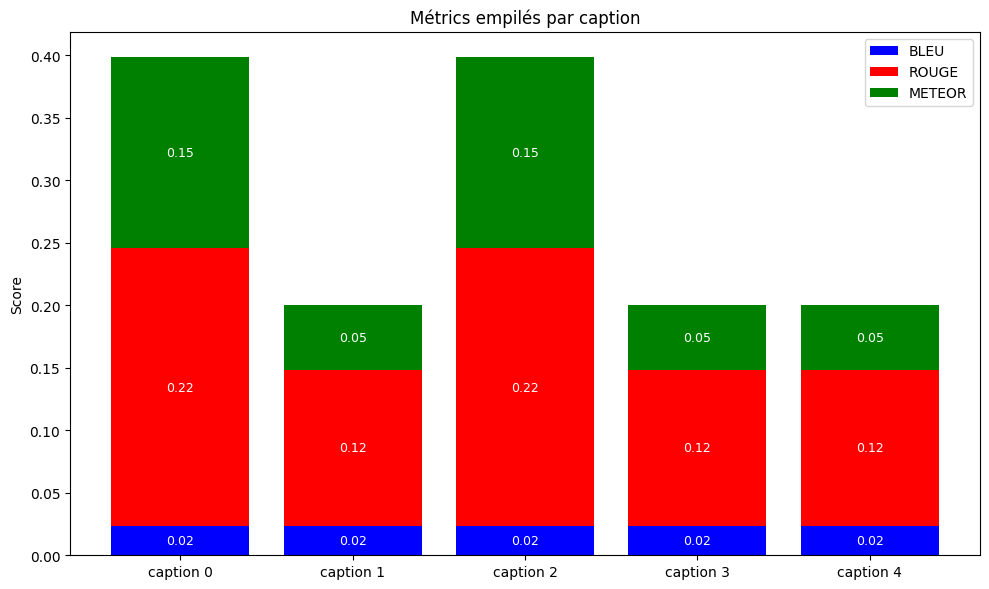

Ceci est un exemple de métriques reprenant les prédictions pour l'exemple n°3. Nous pouvons observer ici que pour le modèle avec les prédictions **LSTM**, ce sont les prédictions 1 et 2 qui semblent avoir les meilleurs résultats selon nos métriques.  
Cela est visible surtout pour les métriques **ROUGE** et **METEOR** où les résultats sur ces 2 prédictions sont quasiment doublés pour le premier et triplés pour le second.

───────────────────

##### 9.3.7.2. **GRU**

In [ ]:
# Metrics
bleus = []
rouges = []
meteors = []
CIDErs= []

#bleu = evaluate_metric.load("bleu", verbose=False)
meteor = evaluate_metric.load("meteor", verbose=False)
rouge = evaluate_metric.load("rouge", verbose=False)
#cider_scorer = Cider()
for i, (caption, attn) in enumerate(valid_captions_GRU, 1):
    predictions = [caption]
    references = [[real_caption]]

    # BLEU
    smooth = SmoothingFunction().method4
    score = sentence_bleu(caption.split(), real_caption.split(), smoothing_function=smooth)
    bleus.append(score)

    # METEOR
    meteors.append(meteor.compute(predictions=predictions, references=references)["meteor"])

    # ROUGE
    rouges.append(rouge.compute(predictions=predictions, references=references)["rougeLsum"])

    gts = {
        "img1": [{"caption": real_caption}],
    }
    res = {
        "img1": [{"caption": caption[0]}],
    }

    # CIDEr & SPICE utilisent java et du coup peuvent faire des erreurs si pas installé ou pas la bonne version 

    # CIDEr
    # PTBtokenizer = PTBTokenizer()
    # gts = PTBtokenizer.tokenize(gts)
    # res = PTBtokenizer.tokenize(res)

    # score, scores = cider_scorer.compute_score(gts, res)
    # CIDErs.append(score)

    # SPICE
    # spice_scorer = Spice()
    # score, scores = spice_scorer.compute_score(gts, res)
    # print(f"SPICE: {score:.4f}")

In [ ]:
x = ["caption " + str(i) for i in range(len(bleus))]
metrics = [bleus, rouges, meteors] #, CIDErs]
labels = ['BLEU', 'ROUGE', 'METEOR'] #, 'CIDEr']
colors = ['blue', 'red', 'green'] #, 'orange']

plt.figure(figsize=(10, 6))
bottom = np.zeros(len(x))  # Hauteur de départ pour chaque segment

for i, (metric, name, color) in enumerate(zip(metrics, labels, colors)):
    bars = plt.bar(x, metric, bottom=bottom, label=name, color=color)

    # Annoter chaque segment
    for xi, yi, base in zip(x, metric, bottom):
        if yi > 0:
            plt.text(xi, base + yi / 2, f'{yi:.2f}', ha='center', va='center', fontsize=9, color='white')

    # Mise à jour de la hauteur de base
    bottom += metric

plt.ylabel('Score')
plt.title('Métrics empilés par caption')
plt.legend()
plt.tight_layout()
plt.show()

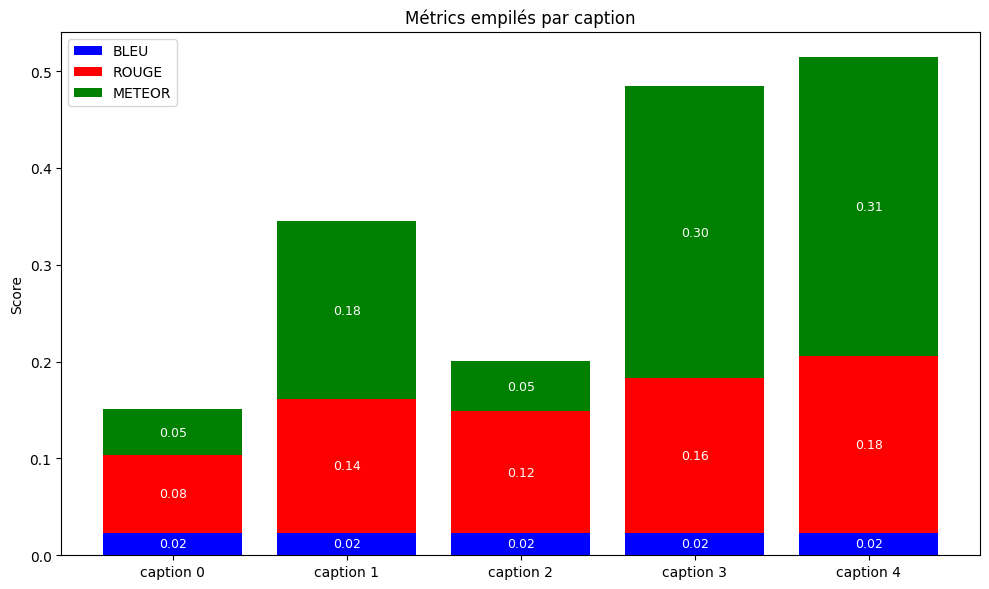

Ceci est un exemple de métriques reprenant les prédictions pour l'exemple n°3. Dans le cas du **GRU**, ce sont les prédictions 4 et 5 qui semblent être les meilleures. Cela est surtout visible avec la métrique **METEOR** qui a un résultat bien supérieur sur ces prédictions que sur les autres.

──────────────────────────────────────────────────

#### 9.4. <a>Évaluation d'un modèle entraîné sur 50 epochs</a>

Cette section va permettre de charger les poids et de tester un modèle qui a été entraîné sur 50 epochs au total, donnant donc naturellement de meilleurs résultats. Ce modèle utilisant un **LSTM** comme décodeur car c'est avec le **LSTM** que nous trouvons les meilleurs prédictions lors des modèles à 20 epochs.

##### 9.4.1. <a>Création du modèle et chargement des poids</a>

In [ ]:
# Tu dois d'abord reconstruire les modèles (même structure qu'au training)
encoder_load_better = CNN_Encoder(embedding_dim)
decoder_load_lstm_better = RNN_Decoder(embedding_dim, units, vocab_size, use_lstm=True)

# Build the models by calling them with dummy data
dummy_image_features = tf.random.normal([1, attention_features_shape, features_shape])
dummy_caption_input = tf.random.uniform([1, 1], minval=0, maxval=vocab_size, dtype=tf.int32)
dummy_hidden_state = tf.zeros((1, units))

# Build the encoder by calling it with dummy data
_ = encoder_load_better(dummy_image_features)

# Build the decoder by calling it with dummy data
dummy_encoder_output = encoder_load(dummy_image_features)
_ = decoder_load_lstm_better(dummy_caption_input, dummy_encoder_output, dummy_hidden_state)


# Puis charger les poids
encoder_load_better.load_weights("models/encoder_better.weights.h5")
decoder_load_lstm_better.load_weights("models/decoder_lstm_better.weights.h5")

##### 9.4.2. <a>Génération des captions</a>

In [ ]:
#import glob
#image_folder = "dataset_livrable_2/Results/denoised_photos/"
#image_files = glob.glob(f"{image_folder}/*.jpg")
#image = random.choice(image_files)
#index = None

#Choisir une image aléatoire
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
index = img_name_val.index(image)
real_caption = ' '.join([
    tokenizer.index_word[i]
    for i in cap_val[index]
    if i not in [0, tokenizer.word_index['<start>'], tokenizer.word_index['<end>']]
])

valid_captions_LSTM_better = []

# Boucle jusqu'à obtenir 5 captions valides par modèle
while len(valid_captions_LSTM_better) < 5:
    result_LSTM_better, attention_plot_LSTM_better = evaluate(image, decoder_load_lstm_better,encoder_load_better)

    predicted_caption_LSTM_better = ' '.join([word for word in result_LSTM_better if word not in ['<start>', '<end>']])

    if len(valid_captions_LSTM_better) < 5 and is_valid_caption(predicted_caption_LSTM_better):
        valid_captions_LSTM_better.append((predicted_caption_LSTM_better, attention_plot_LSTM_better))


# Affichage final
print('Image Path:', image)
print('Real Caption:', real_caption)

# Affichage LSTM
print('LSTM Predictions:')
for i, (caption, attn) in enumerate(valid_captions_LSTM_better, 1):
    print(f'LSTM Prediction {i}:', caption)
    #plot_attention(image, caption.split(), attn)

# Afficher l'image originale
img = Image.open(image)
plt.imshow(img)
plt.axis("off")
plt.title("Image utilisée")
plt.show()

##### 9.4.3 <a>Exemple 1 :</a>

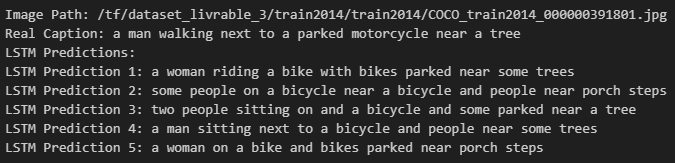

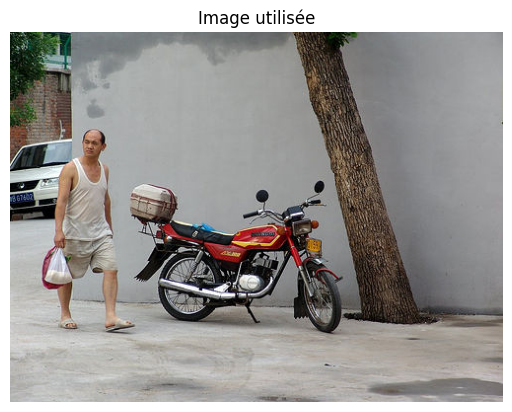

<b style="color:yellow;">TODO</b> Description

##### 9.4.4 <a>Exemple 2 :</a>

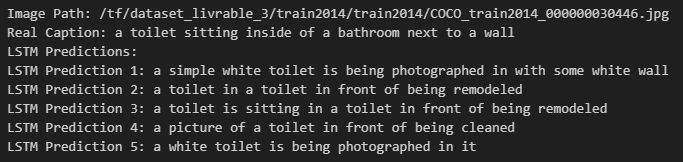

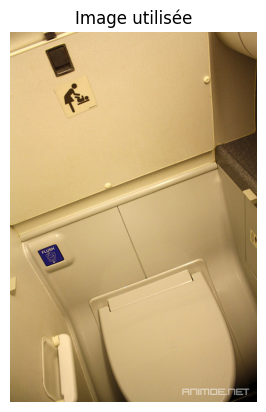

<b style="color:yellow;">TODO</b> Description

##### 9.4.5 <a>Exemple 3 :</a>

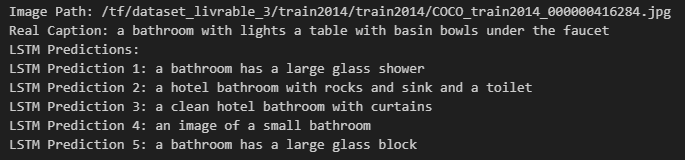

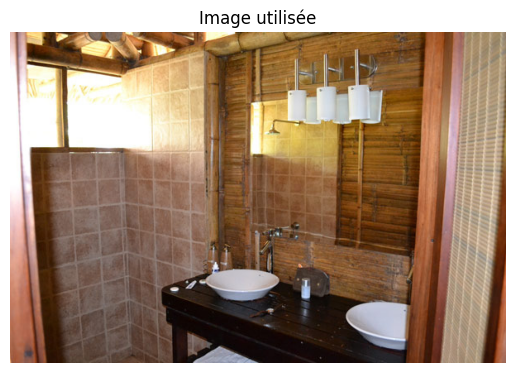

<b style="color:yellow;">TODO</b> Description

##### 9.4.6. <a>Calcul des métriques</a>

In [ ]:
# Metrics
bleus = []
rouges = []
meteors = []
CIDErs= []

#bleu = evaluate_metric.load("bleu", verbose=False)
meteor = evaluate_metric.load("meteor", verbose=False)
rouge = evaluate_metric.load("rouge", verbose=False)
#cider_scorer = Cider()
for i, (caption, attn) in enumerate(valid_captions_LSTM_better, 1):
    predictions = [caption]
    references = [[real_caption]]

    # BLEU
    smooth = SmoothingFunction().method4
    score = sentence_bleu(caption.split(), real_caption.split(), smoothing_function=smooth)
    bleus.append(score)

    # METEOR
    meteors.append(meteor.compute(predictions=predictions, references=references)["meteor"])

    # ROUGE
    rouges.append(rouge.compute(predictions=predictions, references=references)["rougeLsum"])

    gts = {
        "img1": [{"caption": real_caption}],
    }
    res = {
        "img1": [{"caption": caption[0]}],
    }

    # CIDEr & SPICE utilisent java et du coup peuvent faire des erreurs si pas installé ou pas la bonne version 

    # CIDEr
    # PTBtokenizer = PTBTokenizer()
    # gts = PTBtokenizer.tokenize(gts)
    # res = PTBtokenizer.tokenize(res)

    # score, scores = cider_scorer.compute_score(gts, res)
    # CIDErs.append(score)

    # SPICE
    # spice_scorer = Spice()
    # score, scores = spice_scorer.compute_score(gts, res)
    # print(f"SPICE: {score:.4f}")

In [ ]:
x = ["caption " + str(i) for i in range(len(bleus))]
metrics = [bleus, rouges, meteors] #, CIDErs]
labels = ['BLEU', 'ROUGE', 'METEOR'] #, 'CIDEr']
colors = ['blue', 'red', 'green'] #, 'orange']

plt.figure(figsize=(10, 6))
bottom = np.zeros(len(x))  # Hauteur de départ pour chaque segment

for i, (metric, name, color) in enumerate(zip(metrics, labels, colors)):
    bars = plt.bar(x, metric, bottom=bottom, label=name, color=color)

    # Annoter chaque segment
    for xi, yi, base in zip(x, metric, bottom):
        if yi > 0:
            plt.text(xi, base + yi / 2, f'{yi:.2f}', ha='center', va='center', fontsize=9, color='white')

    # Mise à jour de la hauteur de base
    bottom += metric

plt.ylabel('Score')
plt.title('Métrics empilés par caption')
plt.legend()
plt.tight_layout()
plt.show()

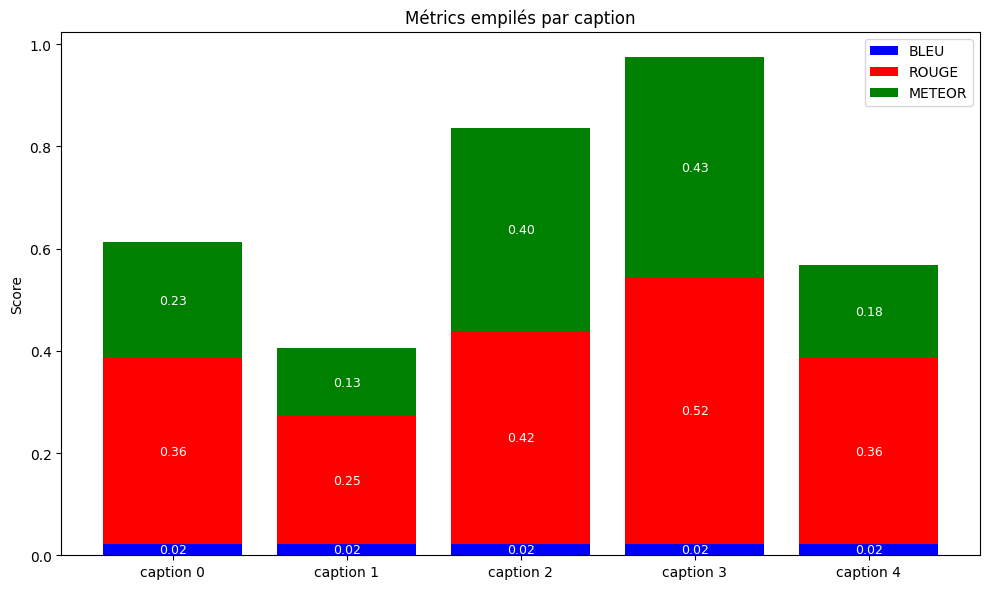

<b style="color:yellow;">TODO</b>

Générer les graphes et analyser les résultats.

---

### 10. <a id="conclusion">Conclusion</a>

Ce livrable nous as permis de concevoir et d’évaluer un système de génération automatique de légendes d’images basé sur une architecture encodeur-décodeur avec mécanisme d’attention. L’encodeur CNN, associé à une attention de type Bahdanau, a efficacement extrait et mis en valeur les caractéristiques visuelles pertinentes. Le décodeur, implémenté en deux variantes (GRU et LSTM), a généré des séquences de texte cohérentes et adaptées aux images.

L’utilisation de l’optimiseur Adam a favorisé un apprentissage stable, et l’évaluation selon les métriques BLEU, METEOR, ROUGE et CIDEr a permis de mesurer avec précision la qualité des légendes produites. Les résultats confirment la pertinence de l’approche retenue pour la tâche de captioning d’images.

---